### Library Import

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("..")


In [2]:
np.random.seed(80)
plt.style.use("seaborn-v0_8-darkgrid")
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

### Load dataset 

In [3]:
from src.sanity import *
from src.load_datasets import load_household_electricity_data


dataframe = (
    load_household_electricity_data()
    .pipe(format_datetime, col="Date_Time")
    .pipe(set_index, col="Date_Time")
    .pipe(resample_data, freq="H")
    #.pipe(interpolate_column)
)

print(f"dataframe shape {dataframe.shape}")

#dataframe = dataframe[
#    ["p (mbar)", "T (degC)", "Tpot (K)", "Tdew (degC)", "rh (%)"]
#].copy(deep=True)

dataframe.head()

format_datetime: DF Shape (2075259, 8)
set_index: DF Shape (2075259, 7)
resample_Data: DF Shape (34589, 7)
dataframe shape (34589, 7)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date_Time,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667


In [4]:
dataframe.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [5]:
# dataframe.info()
# dataframe.isna().sum()
corr = dataframe.corr()
corr.style.background_gradient(cmap="coolwarm")

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Global_active_power,1.000000,0.307192,-0.374436,0.999419,0.495645,0.439244,0.696104
Global_reactive_power,0.307192,1.000000,-0.141156,0.323322,0.325437,0.255332,0.099668
Voltage,-0.374436,-0.141156,1.000000,-0.387831,-0.204854,-0.160202,-0.273985
Global_intensity,0.999419,0.323322,-0.387831,1.000000,0.504097,0.446582,0.686321
Sub_metering_1,0.495645,0.325437,-0.204854,0.504097,1.000000,0.116226,0.195251
Sub_metering_2,0.439244,0.255332,-0.160202,0.446582,0.116226,1.000000,0.123952
Sub_metering_3,0.696104,0.099668,-0.273985,0.686321,0.195251,0.123952,1.000000


### Test Train split

train_xy and test_xy size: (34574, 7), (15, 7)

y_train and x_train size (34574,), (34574, 6)
y_test  and x_test  size (15,),  (15, 6)



(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Sub_metering_3'>)

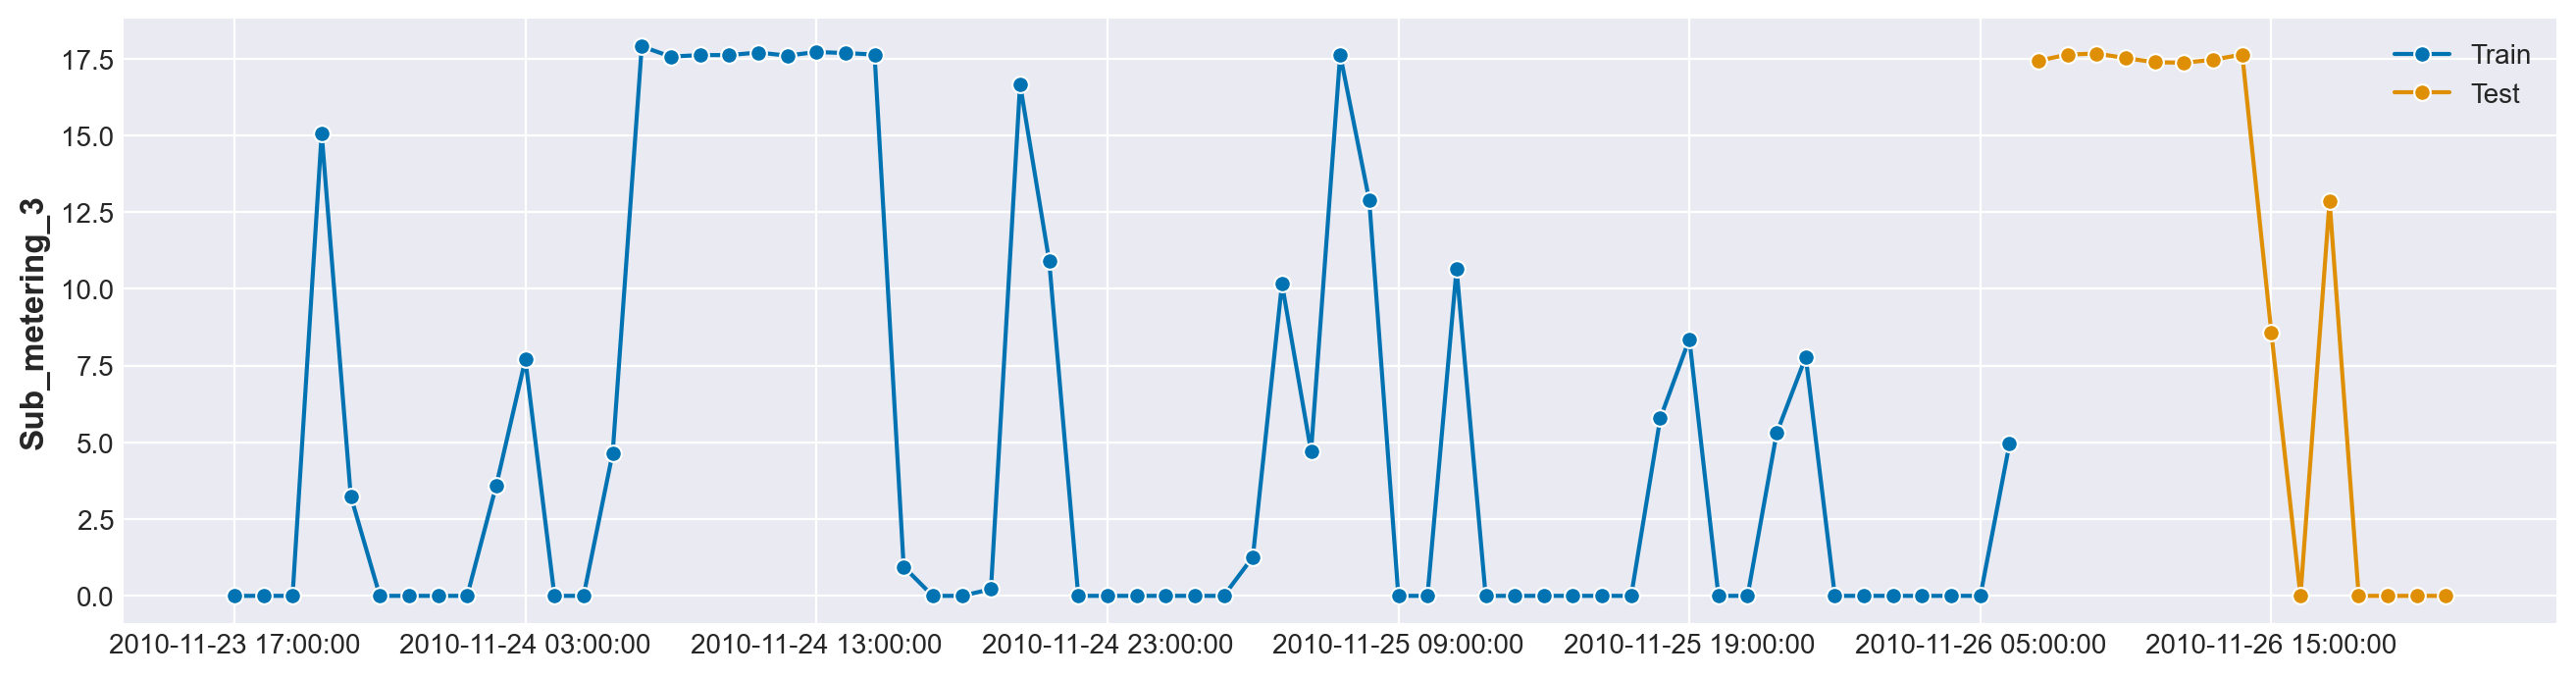

In [6]:
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split

TEST_SIZE = 15
TARGET_COl = "Sub_metering_3"

train_xy, test_xy = temporal_train_test_split(dataframe, test_size=TEST_SIZE)

print(f"train_xy and test_xy size: {train_xy.shape}, {test_xy.shape}", end="\n\n")

y_train = train_xy[TARGET_COl].copy(deep=True)
x_train = train_xy.drop(columns=[TARGET_COl]).copy(deep=True)

y_test = test_xy[TARGET_COl].copy(deep=True)
x_test = test_xy.drop(columns=[TARGET_COl]).copy(deep=True)

print(f"y_train and x_train size {y_train.shape}, {x_train.shape}")
print(
    f"y_test  and x_test  size {y_test.shape},  {x_test.shape}",
    end="\n\n",
)

plot_series(y_train.tail(62), y_test, labels=["Train", "Test"])

#### Huyper Parameter Selection 

intital_window_size 34499 , step_length 15 for fold 5


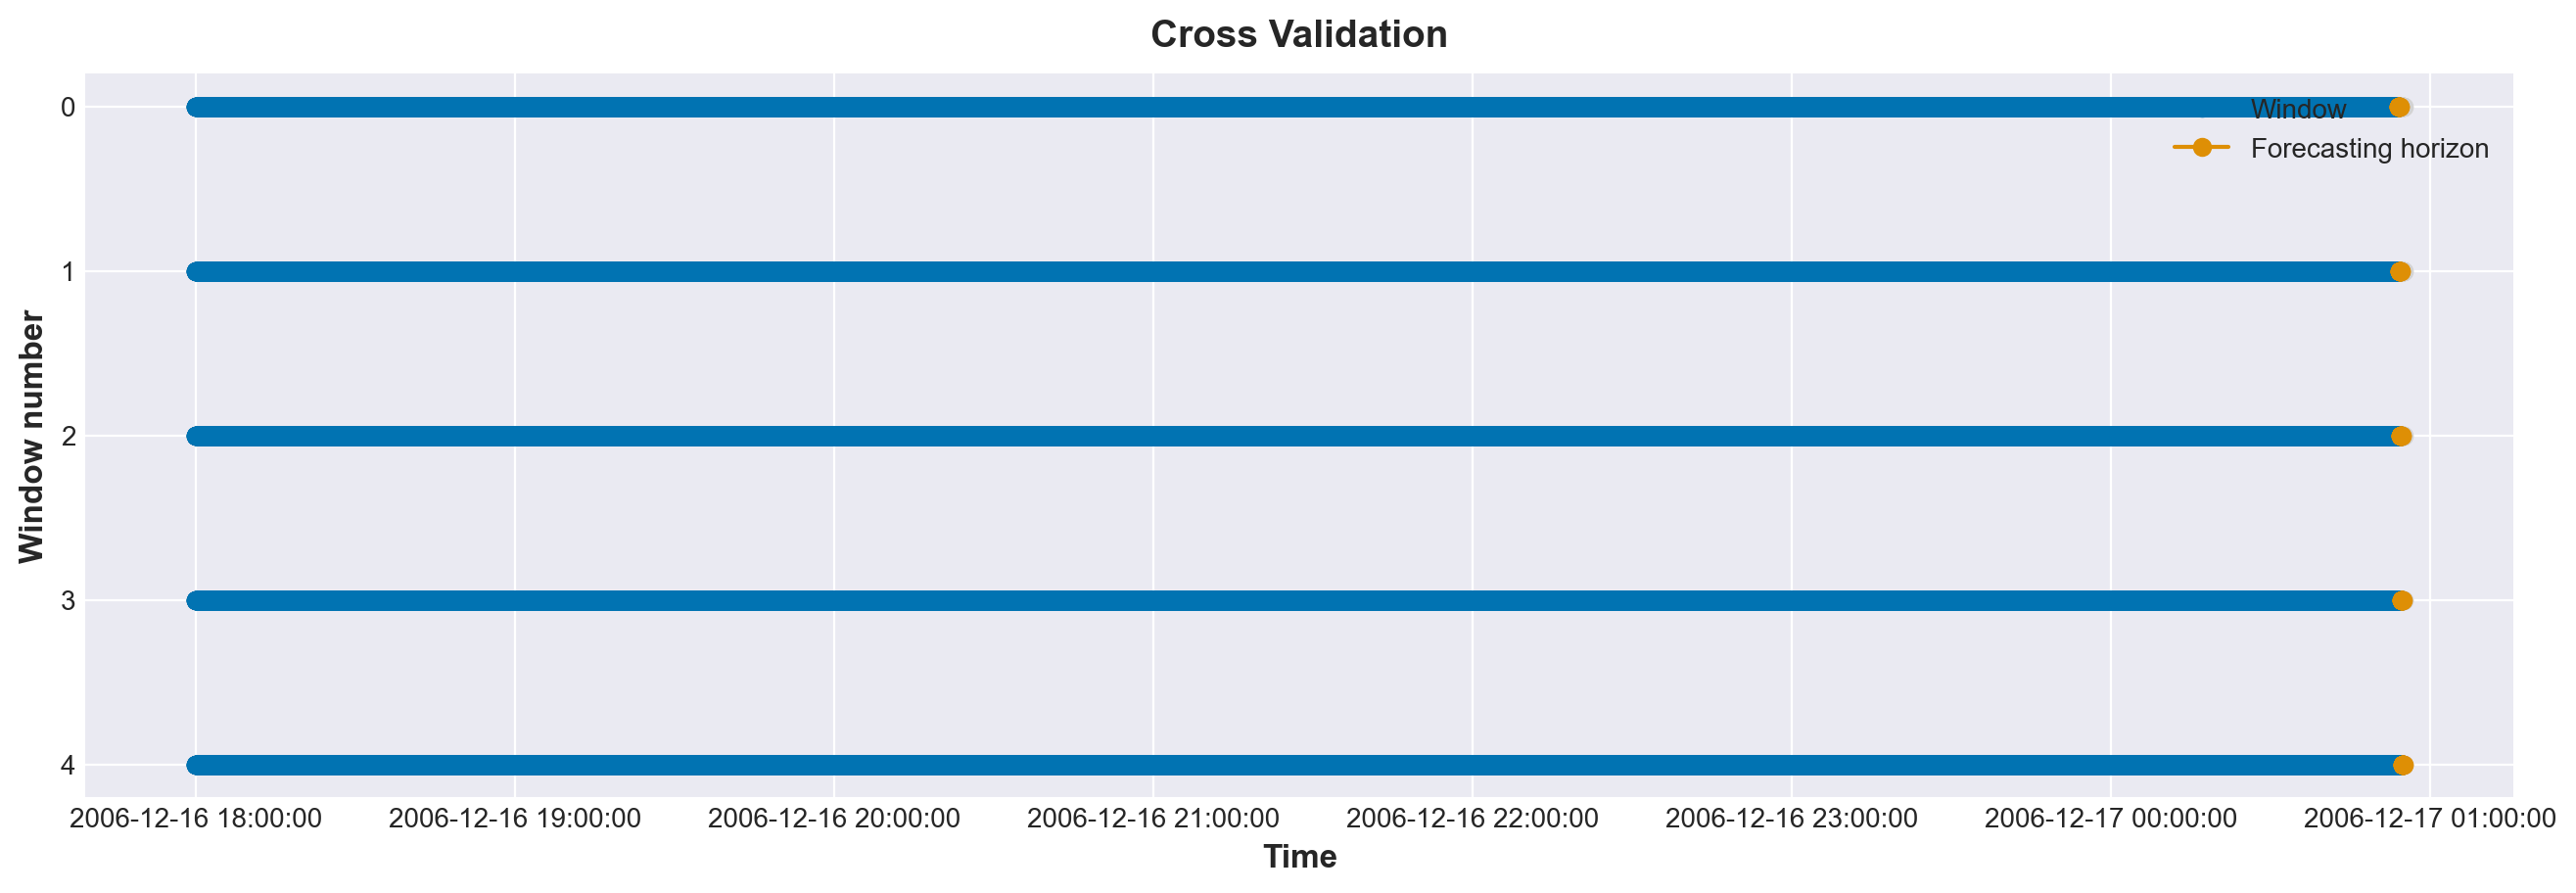

In [7]:
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    SlidingWindowSplitter,
)
from sktime.utils.plotting import plot_windows

fh = np.arange(1, TEST_SIZE + 1)

y_size = len(y_train)

fold = 5

step_length = len(fh)

fh_max_length = max(fh)

intital_window_size = y_size - ((fold - 1) * step_length + 1 * fh_max_length)

# intital_window_size = int(y_train.shape[0] * 0.80)

print(
    f"intital_window_size {intital_window_size} , step_length {step_length} for fold {fold}"
)

cv = ExpandingWindowSplitter(
    fh, initial_window=intital_window_size, step_length=step_length
)

plot_windows(cv, y_train, title="Cross Validation")

In [8]:
%%time

from sklearn.preprocessing import MinMaxScaler

from sktime.forecasting.compose import (
    ForecastingPipeline,
    make_reduction,
    TransformedTargetForecaster,
)
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.compose import TransformerPipeline
from sktime.transformations.series.impute import Imputer


from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.performance_metrics.forecasting import MeanAbsoluteError

from scikeras.wrappers import KerasRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Reshape
from tensorflow.keras.optimizers import Adam
      

def simple_lstm_dense(in_feats:int ,window_length: int, n_unit: int):
    model = Sequential()
    model.add(Reshape((window_length,in_feats), input_shape=(window_length*in_feats,)))
    model.add(LSTM(n_unit, activation='relu',return_sequences=True))
    model.add(LSTM(n_unit, activation='relu',return_sequences=False))
    model.add(Dense(1))
    model.compile(loss="mse", optimizer=Adam(learning_rate=0.01), metrics='mae')
    return model

param_grid = {
    "forecaster__reducer__window_length": [24],
    "forecaster__reducer__estimator__epochs": [25],
    "forecaster__reducer__estimator__batch_size": [64],
}

regressor = KerasRegressor(model=simple_lstm_dense(7,24,64), 
                           epochs=100, 
                           batch_size=None, 
                           verbose=10)

forecaster_pipe = ForecastingPipeline(
    steps=[
        (
            "x_transforner",
            TransformerPipeline(
                steps=[("imputer_x", Imputer(method="ffill", random_state=80))]
            ),
        ),
        ("scaler_x",TabularToSeriesAdaptor(MinMaxScaler()) ),
        (
            "forecaster",
            TransformedTargetForecaster(
                steps=[
                    ("imputer_y", Imputer(method="ffill", random_state=80)),
                    ("scaler_y",TabularToSeriesAdaptor(MinMaxScaler()) ),
                    (
                        "reducer",
                        make_reduction(
                            estimator=regressor,
                            scitype="tabular-regressor",
                            window_length=10,
                            strategy="recursive",
                            pooling="local",
                        ),
                    ),
                ]
            ),
        ),
    ]
)

fh = np.arange(1, TEST_SIZE + 1)

cv = ExpandingWindowSplitter(
    fh, initial_window=intital_window_size, step_length=step_length
)

print(f"Number of CPU Count:   {os.cpu_count()}")

n_cpu = os.cpu_count() - 1 if os.cpu_count() > 2 else 1

gscv = ForecastingGridSearchCV(
    forecaster_pipe,
    strategy="refit",
    scoring=MeanAbsoluteError(),
    cv=cv,
    param_grid=param_grid,
    verbose=10,
    n_jobs=n_cpu,
    refit=True,
    error_score="raise",
)

gscv.fit(y_train, X=x_train, fh=fh)

print("Best Params", gscv.best_params_)
print("Best scores", gscv.best_score_)
# print('Best Params', gscv.best_forecaster_)

Number of CPU Count:   12
Fitting 5 folds for each of 1 candidates, totalling 5 fits


INFO:tensorflow:Assets written to: C:\Users\rdas6\AppData\Local\Temp\tmp9ql86mlf\assets


INFO:tensorflow:Assets written to: C:\Users\rdas6\AppData\Local\Temp\tmp9ql86mlf\assets


INFO:tensorflow:Assets written to: C:\Users\rdas6\AppData\Local\Temp\tmpvkjm0shx\assets


INFO:tensorflow:Assets written to: C:\Users\rdas6\AppData\Local\Temp\tmpvkjm0shx\assets


Epoch 1/25
Epoch 2/25
Epoch 3/25
Epoch 4/25
Epoch 5/25
Epoch 6/25
Epoch 7/25
Epoch 8/25
Epoch 9/25
Epoch 10/25
Epoch 11/25
Epoch 12/25
Epoch 13/25
Epoch 14/25
Epoch 15/25
Epoch 16/25
Epoch 17/25
Epoch 18/25
Epoch 19/25
Epoch 20/25
Epoch 21/25
Epoch 22/25
Epoch 23/25
Epoch 24/25
Epoch 25/25


INFO:tensorflow:Assets written to: C:\Users\rdas6\AppData\Local\Temp\tmpby5wjjt6\assets


INFO:tensorflow:Assets written to: C:\Users\rdas6\AppData\Local\Temp\tmpby5wjjt6\assets


Epoch 1/25
Epoch 2/25
Epoch 3/25
Epoch 4/25
Epoch 5/25
Epoch 6/25
Epoch 7/25
Epoch 8/25
Epoch 9/25
Epoch 10/25
Epoch 11/25
Epoch 12/25
Epoch 13/25
Epoch 14/25
Epoch 15/25
Epoch 16/25
Epoch 17/25
Epoch 18/25
Epoch 19/25
Epoch 20/25
Epoch 21/25
Epoch 22/25
Epoch 23/25
Epoch 24/25
Epoch 25/25
Best Params {'forecaster__reducer__estimator__batch_size': 64, 'forecaster__reducer__estimator__epochs': 25, 'forecaster__reducer__window_length': 24}
Best scores 5.671183993565618
CPU times: total: 12min 19s
Wall time: 1h 3min 2s


In [9]:
print(x_test.columns)

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2'],
      dtype='object')


2010-11-26 07:00:00    16.006737
2010-11-26 08:00:00    17.153133
2010-11-26 09:00:00    15.977949
2010-11-26 10:00:00    13.119733
2010-11-26 11:00:00     4.955773
2010-11-26 12:00:00     5.742055
2010-11-26 13:00:00    16.804930
2010-11-26 14:00:00    12.958605
2010-11-26 15:00:00     2.899221
2010-11-26 16:00:00     2.497572
2010-11-26 17:00:00     6.687047
2010-11-26 18:00:00    16.814415
2010-11-26 19:00:00    11.165421
2010-11-26 20:00:00     2.608137
2010-11-26 21:00:00     3.059831
Freq: H, Name: Sub_metering_3, dtype: float64

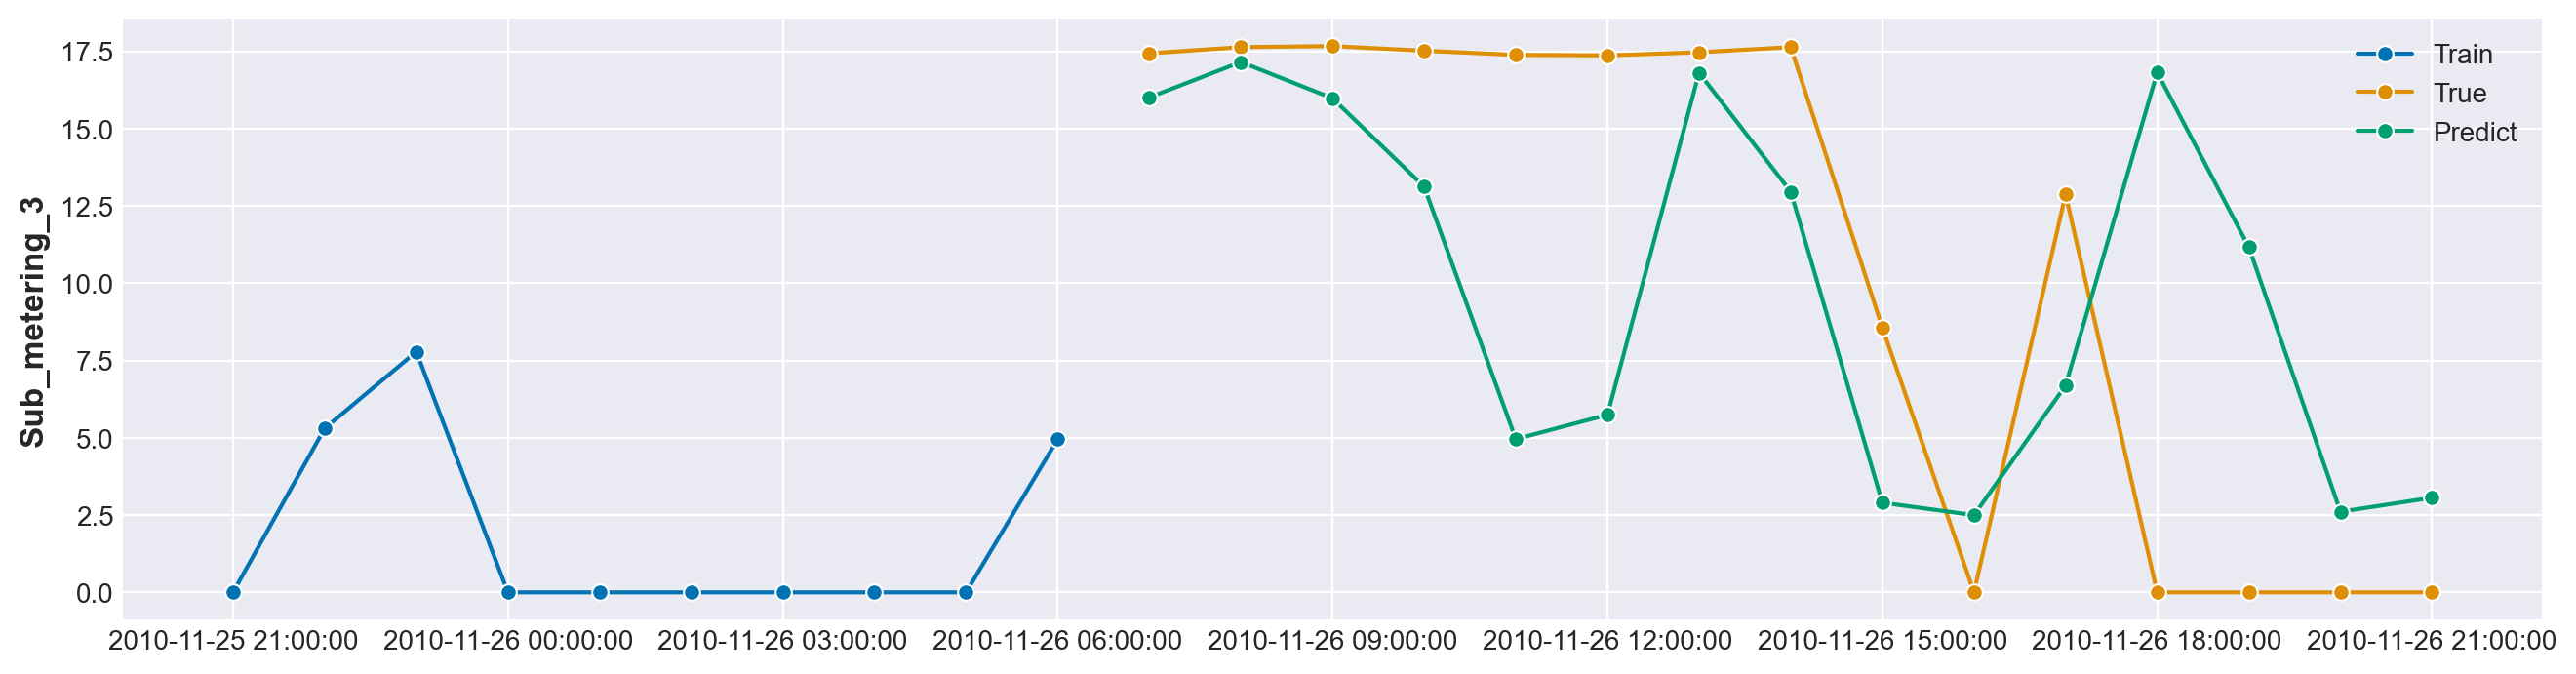

In [10]:
y_predict = gscv.predict(fh=fh, X=x_test)
plot_series(y_train.tail(10), y_test, y_predict, labels=["Train", "True", "Predict"])
y_predict

In [11]:
print(gscv.cv_results_.shape)
gscv.cv_results_.head()

(1, 5)


,mean_test_MeanAbsoluteError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsoluteError
0,5.671184,541.970733,1.240798,{'forecaster__reducer__estimator__batch_size':...,1.0


### Backtesting Insample Prediction

In [ ]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import (
    MeanSquaredError,
    MeanAbsoluteError,
    MeanAbsolutePercentageError,
    MeanAbsoluteScaledError,
)

losses = [
    MeanSquaredError(),
    MeanSquaredError(square_root=True),
    MeanAbsoluteError(),
    MeanAbsolutePercentageError(),
    MeanAbsolutePercentageError(symmetric=False),
    MeanAbsoluteScaledError(),
]

results = evaluate(
    forecaster=gscv.best_forecaster_,
    y=y_train,
    X=x_train,
    cv=cv,
    scoring=losses,
    return_data=True,
)
results

INFO:tensorflow:Assets written to: C:\Users\rdas6\AppData\Local\Temp\tmp70u1rzgc\assets


INFO:tensorflow:Assets written to: C:\Users\rdas6\AppData\Local\Temp\tmp70u1rzgc\assets


Epoch 1/25
Epoch 2/25
Epoch 3/25
Epoch 4/25
Epoch 5/25
Epoch 6/25
Epoch 7/25


In [ ]:
plot_series(
    y_train.tail(100),
    *results["y_pred"].to_list(),
    labels=["y_pred"] + [f"y_pred_{i}" for i in results.index],
)

### Get best model Parameters

In [ ]:
gscv.best_forecaster_.get_fitted_params()

### Train Model Parameter

In [ ]:
model_n_features_in = gscv.best_forecaster_.get_fitted_params()[
    "forecaster__reducer__estimator__n_features_in"
]
model_fname_in = gscv.best_forecaster_.get_fitted_params()[
    "forecaster__reducer__estimator__feature_names_in"
]
#model_coeff = gscv.best_forecaster_.get_fitted_params()[
#    "forecaster__reducer__estimator__coef"
#]
#model_intercept = gscv.best_forecaster_.get_fitted_params()[
#    "forecaster__reducer__estimator__intercept"
#]

print(f"model_n_features_in {model_n_features_in}", end="\n\n")
print(f"model_fname_in {model_fname_in}", end="\n\n")
#print(f"model_coeff {model_coeff}", end="\n\n")
#print(f"model_intercept {model_intercept}", end="\n\n")

### model cutoff

In [ ]:
print(gscv.best_forecaster_.cutoff, y_train.index[-1])

### Model Cloning

In [ ]:
from sklearn.base import clone

model = clone(gscv.best_forecaster_).set_params(**gscv.best_params_)

dir(model)

### Model saving 

In [ ]:
# gscv.best_forecaster_.save("../results/elastic_net")

import joblib

joblib.dump(gscv.best_forecaster_, "../results/Knn_model.pkl")

### Features importance

In [ ]:
pd.DataFrame(model_coeff, index=model_fname_in, columns=["Coeff"]).plot(
    kind="barh", alpha=0.75
)